# House Prices - Regression

This pet project is based on a kaggle competition: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

We are given 79 explanatory variables describing every aspect of residential homes in Ames, Iowa. The task is to predict the final price of each home.

Steps:

1. Data Cleaning. At this step we remove irrelevant observations, address missing values, reformat data types.
2. Exploratory Data Analysis (EDA). Creating visualisations and getting a deeper understanding of the data.
3. Feature Engineering.  Transforming raw data into features that better represent the underlying problem to the predictive model.
4. Modelling. Building machine learning models, tuning the hyperparameters and testing.

In [1]:
# Importing libreris

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

import time

In [2]:
# Loading the data

df = pd.read_csv('df.csv')

# 1. Data Cleaning

In [3]:
# Main info about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# Separating Id 

df_id = df.pop('Id')

The first step is separation of categorical features from numerical.

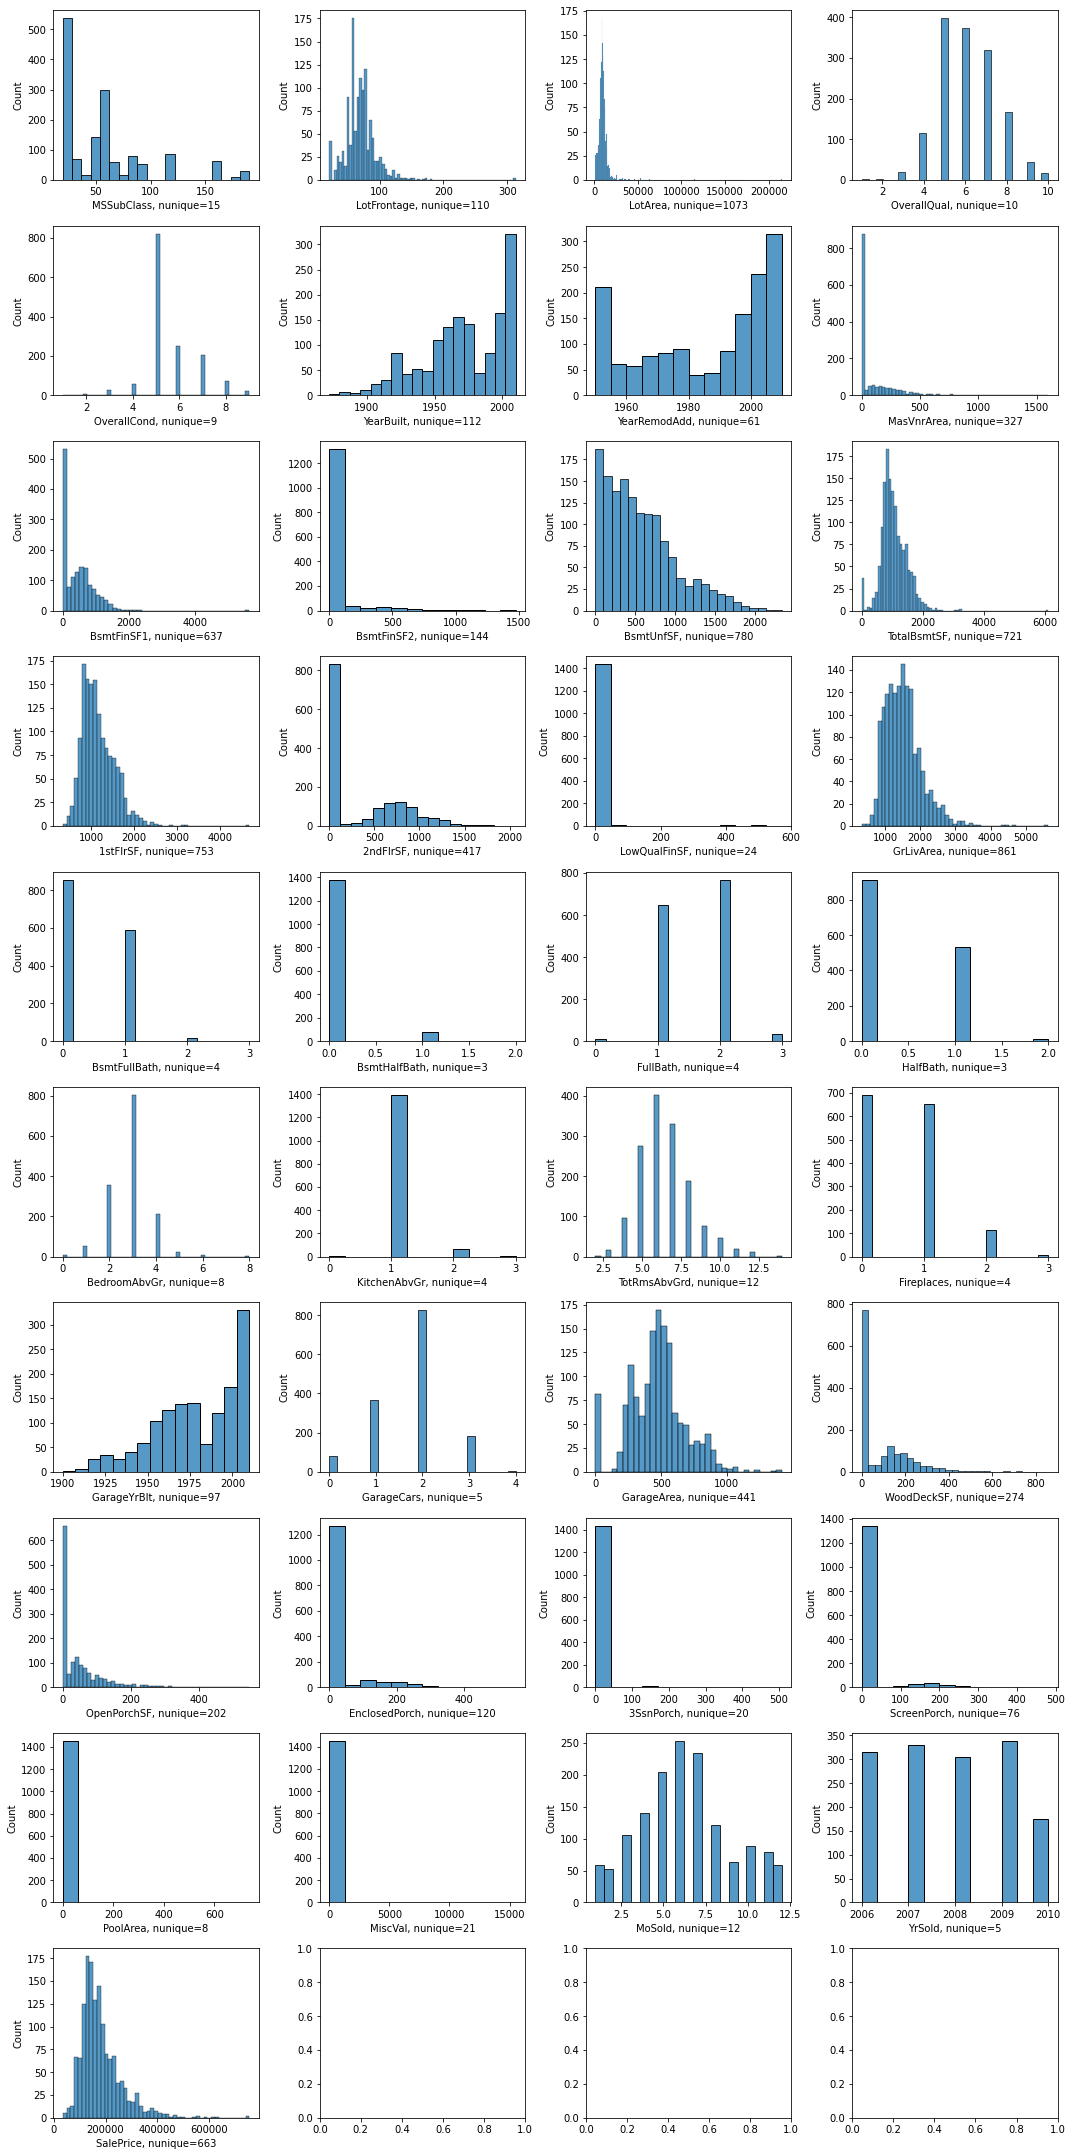

In [5]:
# Distribution of features of non-obcet type, wiht the amount of unique values

int_float_features = df.select_dtypes(exclude=object).columns

fig, axs = plt.subplots(10, 4, figsize=(15, 30))

for i, feature in enumerate(int_float_features):
    sns.histplot(df[feature], ax=axs[i//4, i%4]).set(xlabel=feature + ', nunique=' + str(df[feature].nunique()))

plt.tight_layout()

We can see that all the features that have less than 20 unique values, except for the 'PoolArea', are categorical

In [6]:
# Defining the categorical and numerical features

cat_features = np.concatenate([df.select_dtypes(include=object).columns, 
                              [feature for feature in df.select_dtypes(exclude=object).columns if df[feature].nunique() < 20 
                               and feature != 'PoolArea']])

num_features = df.drop(np.append(cat_features, 'SalePrice'), axis=1).columns.values

print('Amount of num_features: {};\namount of cat_features: {}.'.format(len(num_features), len(cat_features)))

Amount of num_features: 22;
amount of cat_features: 57.


In [7]:
# Missing data

features_with_nan = [feature for feature in df.columns if df[feature].isnull().sum() > 1]
percentage_of_nan = [round(df[feature].isnull().sum() / len(df[feature]) * 100, 2) for feature in features_with_nan]
values = []

for feature in features_with_nan:
    if df[feature].dtype == object:
        values.append(df[feature].unique())
    else:
        values.append([df[feature].min(), df[feature].max()])

pd.set_option('max_colwidth', None)
        
pd.DataFrame(data={'Feature': features_with_nan, 'PercentageOfNan': percentage_of_nan, 'ValuesRange': values})

,Feature,PercentageOfNan,ValuesRange
0,LotFrontage,17.74,"[21.0, 313.0]"
1,Alley,93.77,"[nan, Grvl, Pave]"
2,MasVnrType,59.73,"[BrkFace, nan, Stone, BrkCmn]"
3,MasVnrArea,0.55,"[0.0, 1600.0]"
4,BsmtQual,2.53,"[Gd, TA, Ex, nan, Fa]"
5,BsmtCond,2.53,"[TA, Gd, nan, Fa, Po]"
6,BsmtExposure,2.60,"[No, Gd, Mn, Av, nan]"
7,BsmtFinType1,2.53,"[GLQ, ALQ, Unf, Rec, BLQ, nan, LwQ]"
8,BsmtFinType2,2.60,"[Unf, BLQ, nan, ALQ, Rec, LwQ, GLQ]"
9,FireplaceQu,47.26,"[nan, TA, Gd, Fa, Ex, Po]"


In [8]:
# Filling nans

df[cat_features] = df[cat_features].fillna('No_info')
df[num_features] = df[num_features].fillna(df[num_features].median())

# 2. EDA

<Axes: xlabel='SalePrice', ylabel='Count'>

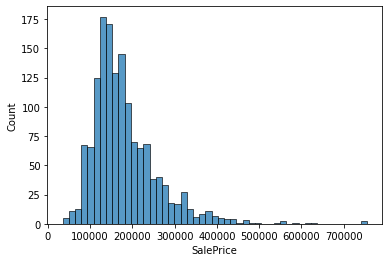

In [9]:
sns.histplot(df['SalePrice'])

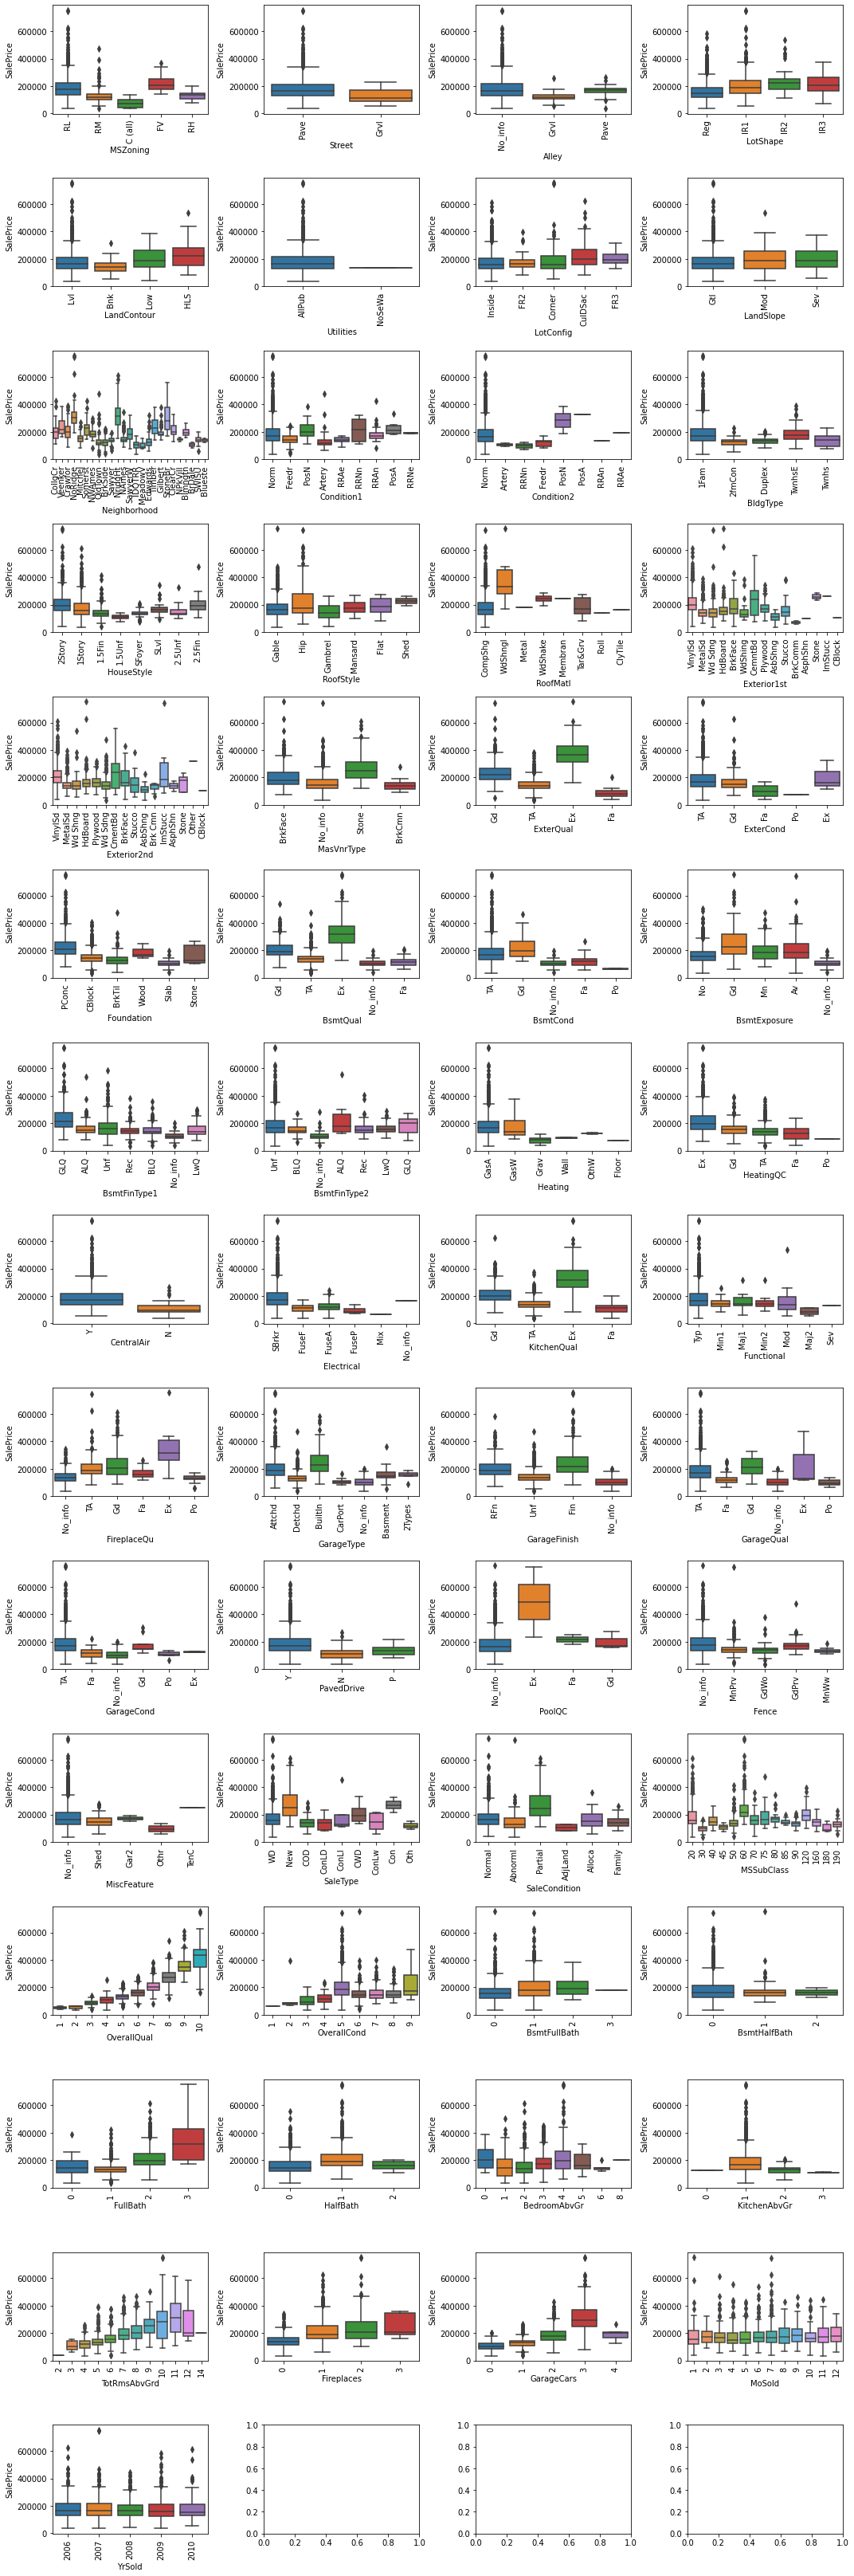

In [10]:
# Plotting target vs categorical features

fig, axs = plt.subplots(15, 4, figsize=(15, 45))

for i, feature in enumerate(cat_features):
    sns.boxplot(x=df[feature], y=df['SalePrice'], ax=axs[i//4, i%4])
    plt.setp(axs[i//4, i%4].get_xticklabels(), rotation=90)
    
fig.tight_layout()

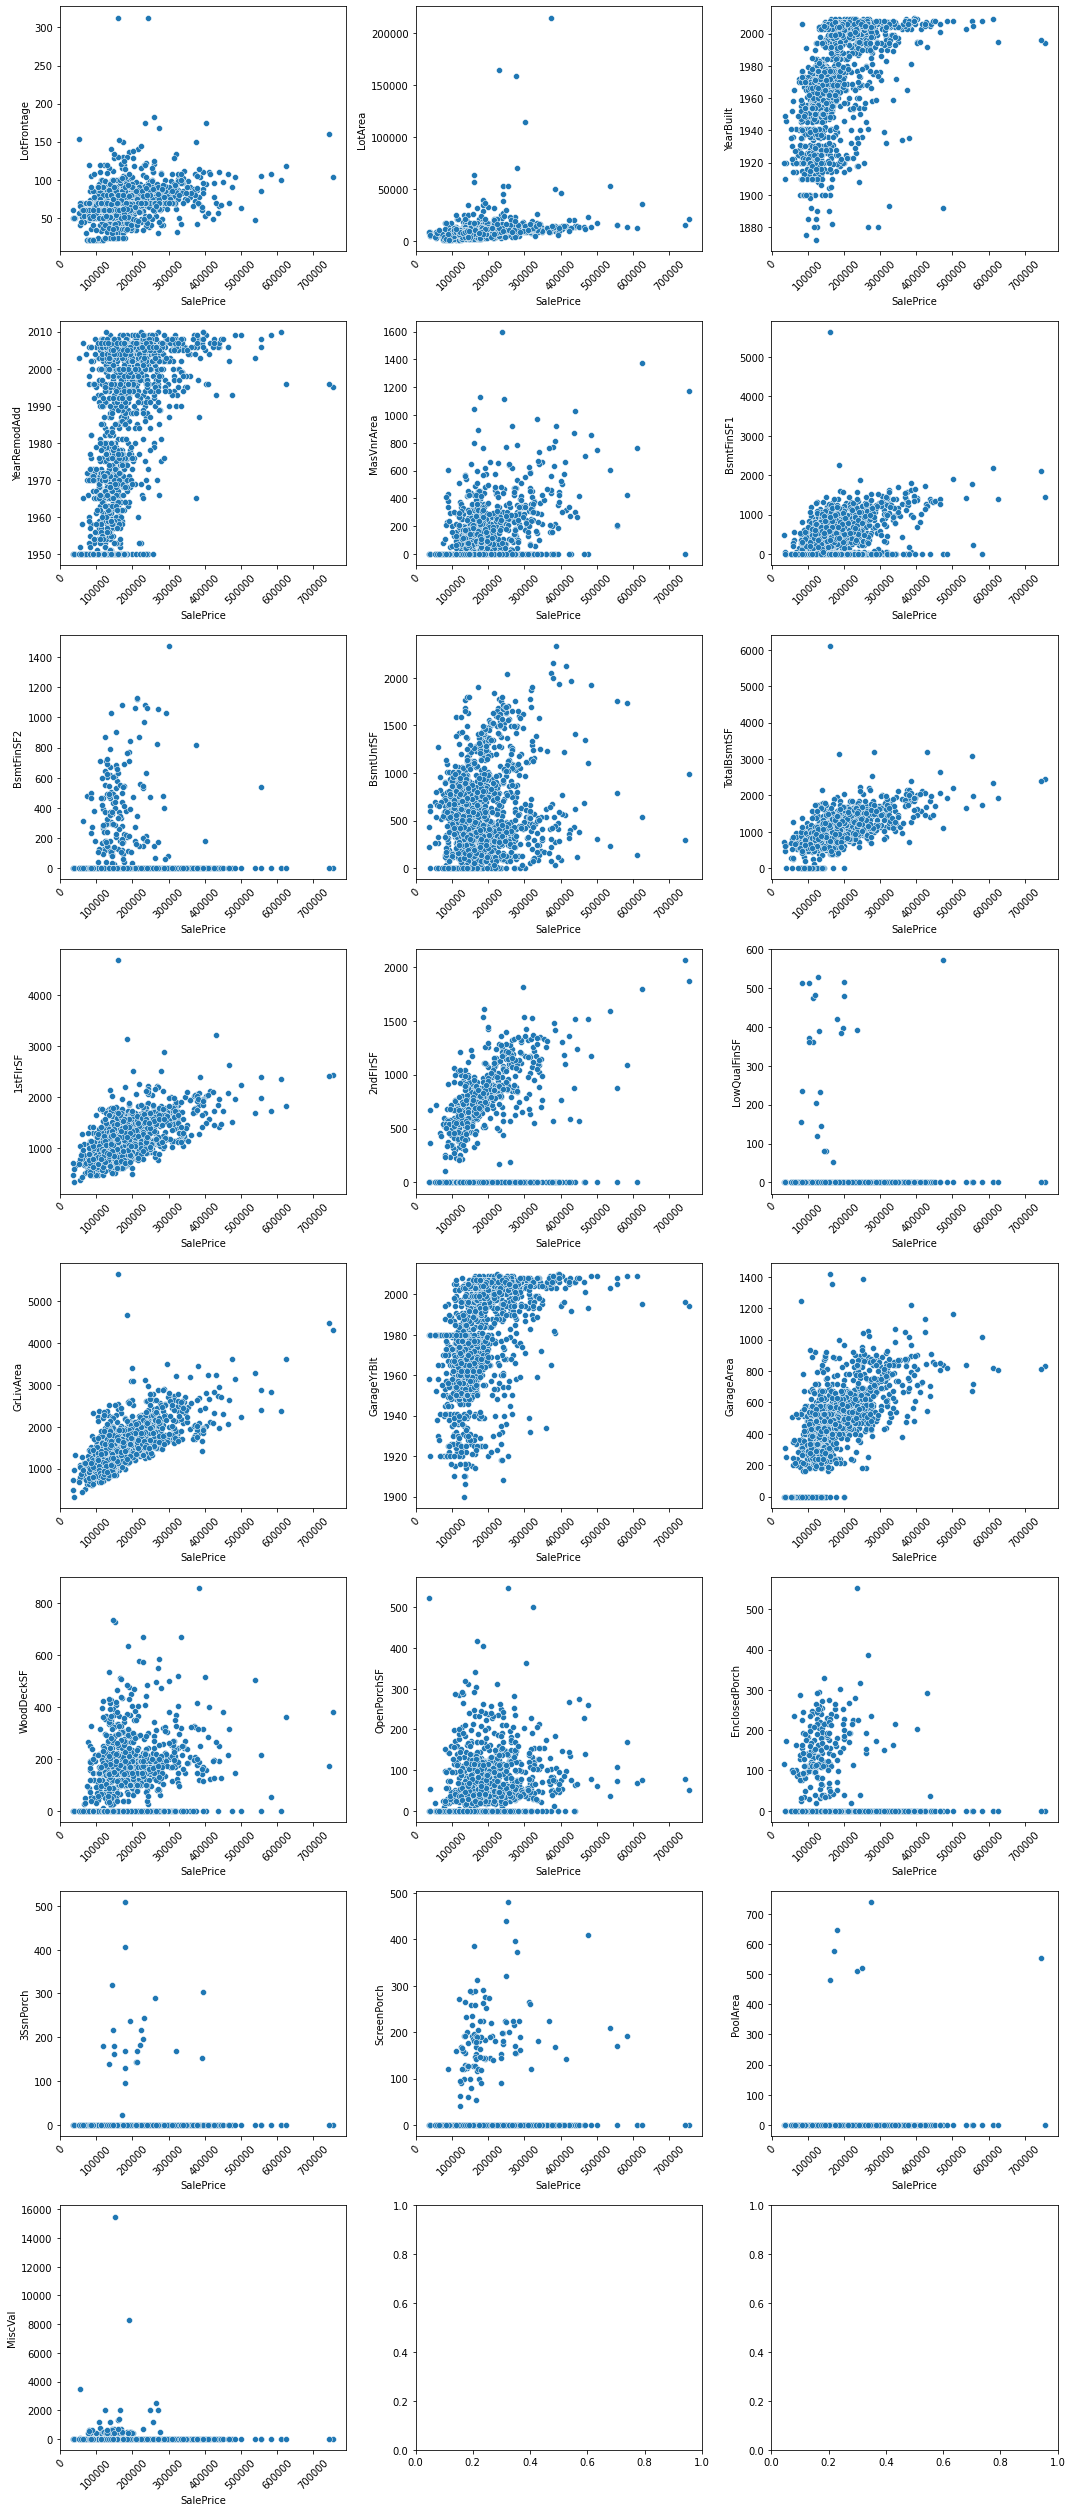

In [11]:
# Plotting target vs numerical features

fig, axis = plt.subplots(8, 3, figsize=(15, 35))

for i, feature in enumerate(num_features):
    sns.scatterplot(x='SalePrice', y=feature, data=df, ax=axis[i//3, i%3])
    plt.setp(axis[i//3, i%3].get_xticklabels(), rotation=45)

fig.tight_layout()

# 3. Feature Engineering

Now let's remove outliers

In [12]:
num_features

array(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype=object)

In [13]:
df_preproc = df.copy()

for feature in ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 
                'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'SalePrice']:
    iqr = 1.5 * (np.percentile(df_preproc[feature], 75) - np.percentile(df_preproc[feature], 25))
    df_preproc = df_preproc.drop(df_preproc[df_preproc[feature] > (np.percentile(df_preproc[feature], 90) + iqr)].index)
#     df_preproc = df_preproc.drop(df_preproc[df_preproc[feature] < (np.percentile(df_preproc[feature], 25) - iqr)].index)

<Axes: xlabel='SalePrice', ylabel='Count'>

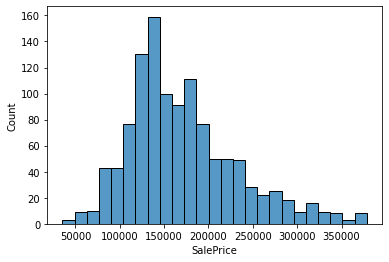

In [14]:
sns.histplot(df_preproc['SalePrice'])

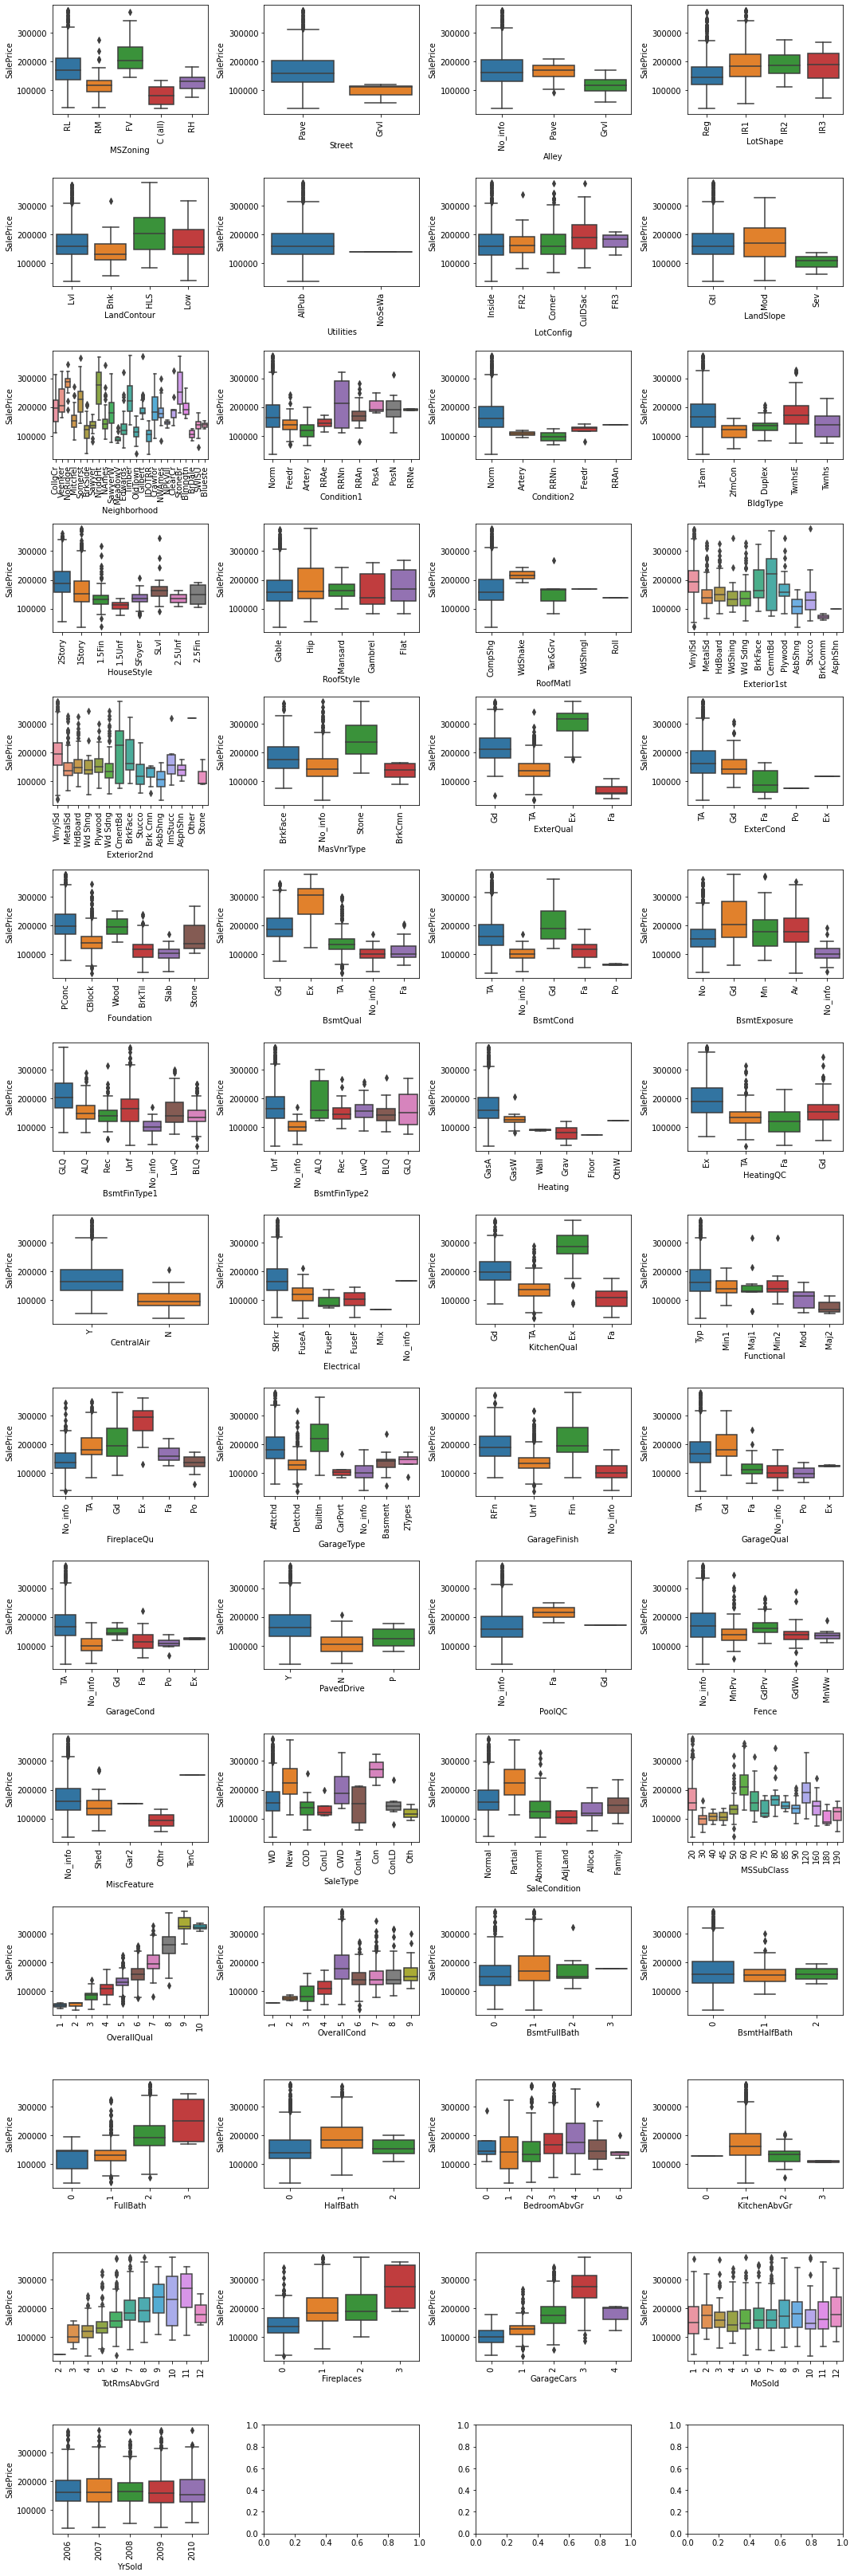

In [15]:
# Plotting target vs categorical features

fig, axs = plt.subplots(15, 4, figsize=(15, 45))

for i, feature in enumerate(cat_features):
    sns.boxplot(x=df_preproc[feature], y=df_preproc['SalePrice'], ax=axs[i//4, i%4])
    plt.setp(axs[i//4, i%4].get_xticklabels(), rotation=90)
    
fig.tight_layout()

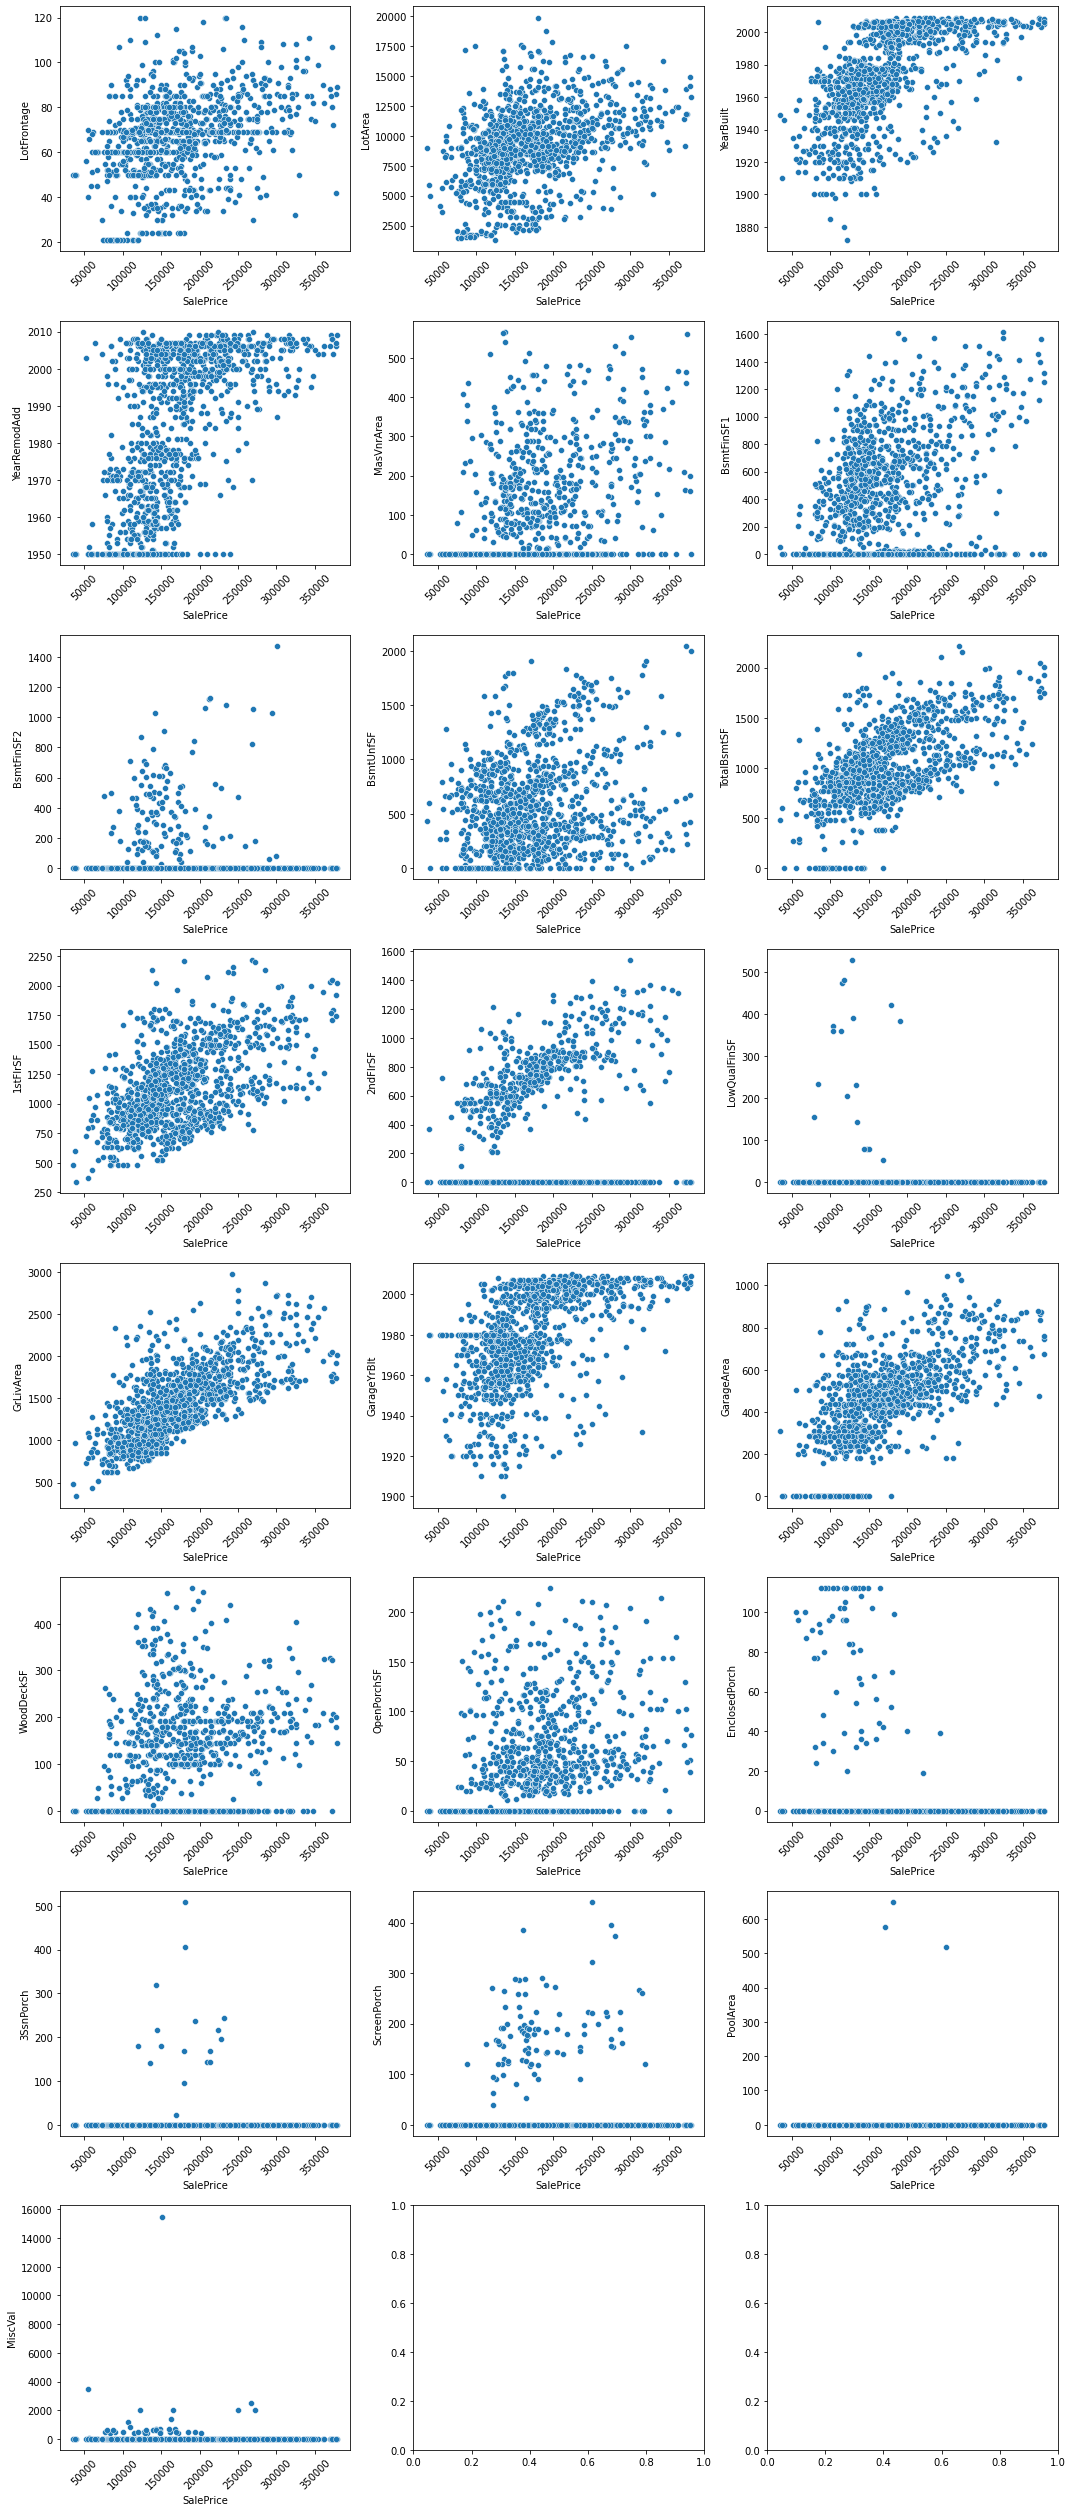

In [16]:
fig, axis = plt.subplots(8, 3, figsize=(15, 35))

for i, feature in enumerate(num_features):
    sns.scatterplot(x='SalePrice', y=feature, data=df_preproc, ax=axis[i//3, i%3])
    plt.setp(axis[i//3, i%3].get_xticklabels(), rotation=45)

fig.tight_layout()

In [17]:
# Encoding categorical features

df_dummy_preproc = pd.get_dummies(df_preproc)

print(df.shape)
print(df_preproc.shape)
print(df_dummy_preproc.shape)

(1460, 80)
(1148, 80)
(1148, 290)


# 4. Modelling

In [18]:
# Splitting the data on train and test sets and building a gradient boosting model

X_train, X_test, y_train, y_test = train_test_split(df_dummy_preproc.drop('SalePrice', axis=1),
                                                    df_dummy_preproc['SalePrice'], random_state=1)

gb = GradientBoostingRegressor(random_state=1)

gb.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

In [19]:
print('R2 GB = ', gb.score(X_test, y_test))

print('RMSE GB = ', mean_squared_error(np.log(y_test), np.log(gb.predict(X_test)), squared=False))

R2 GB =  0.908177488170189
RMSE GB =  0.11930249289106823


[Text(0, 0, 'OverallQual'),
 Text(1, 0, 'GrLivArea'),
 Text(2, 0, 'YearBuilt'),
 Text(3, 0, 'GarageArea'),
 Text(4, 0, 'TotalBsmtSF'),
 Text(5, 0, 'BsmtFinSF1'),
 Text(6, 0, '1stFlrSF'),
 Text(7, 0, 'BsmtQual_Ex'),
 Text(8, 0, 'GarageCars'),
 Text(9, 0, 'YearRemodAdd'),
 Text(10, 0, 'LotArea'),
 Text(11, 0, 'ExterQual_TA'),
 Text(12, 0, 'OverallCond'),
 Text(13, 0, 'Fireplaces'),
 Text(14, 0, 'LotFrontage')]

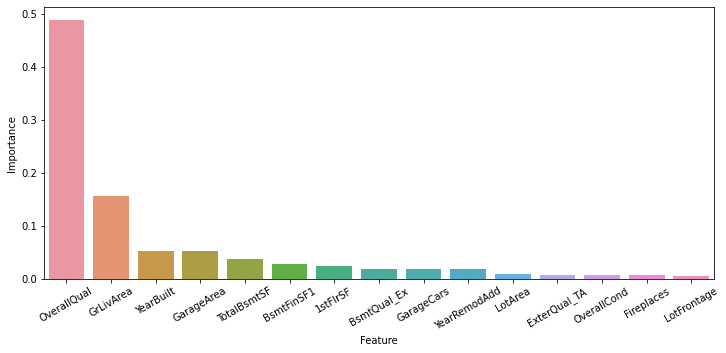

In [20]:
# Choosing important features to apply cross validation on them

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': gb.feature_importances_}) \
                  .sort_values(by='Importance', ascending=False)

important_features = importance_df['Feature'].head(15)

plt.figure(figsize = (12, 5))
ax = sns.barplot(x=importance_df.head(15)['Feature'], y=importance_df.head(15)['Importance'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

In [21]:
params = {'n_estimators': [300, 500, 700], 
          'max_depth': [1, 2, 3],
          'min_samples_split': [10, 12, 14],
          'min_samples_leaf': [8, 10, 12]}

start = time.time()
search = RandomizedSearchCV(gb, params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5, random_state=1)
search.fit(X_train, y_train)
end = time.time()

print(search.best_params_)
print(end - start)

{'n_estimators': 500, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_depth': 2}
38.588669776916504


In [22]:
print('R2 GB = ', search.best_estimator_.score(X_test, y_test))

print('RMSE GB = ', mean_squared_error(np.log(y_test), np.log(search.best_estimator_.predict(X_test)), squared=False))

R2 GB =  0.9221040712728972
RMSE GB =  0.11465495055893003
